In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import cv2
import imageio
import matplotlib.pyplot as plt
import seaborn as sns

import re
import os

from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop

from nltk.corpus import stopwords
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import WordPunctTokenizer

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

tokenizer = WordPunctTokenizer()
STOPWORDS = list(set(stopwords.words('french') + ['/'])) + list(fr_stop)
print("total stop words:", len(STOPWORDS))

total stop words: 758


In [2]:
df = pd.read_csv("../input/sport-fr/eurosport_fr.csv")
print(df.shape)
df = df.loc[df.text.notnull()].reset_index(drop=True)
df.shape

(42060, 6)


(41753, 6)

In [3]:
df['category'].replace({'formule-1':"course", 'auto-moto':"course", 'motocyclisme':"course"}, inplace=True)
df.category.value_counts()

In [4]:
def preprocess_text(text):
    try:
        text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
        text = re.sub(' +', ' ', text)
    except:
        pass
    return text


texts = df.text.dropna().tolist()
texts = [preprocess_text(x) for x in texts if x not in STOPWORDS]
print(len(texts))

41753


In [5]:

corpus = texts
pipe = Pipeline([('count', CountVectorizer()),
                 ('tfid', TfidfTransformer(sublinear_tf=True))]).fit(corpus)
#pipe['count'].transform(corpus).toarray()
#pipe['tfid'].idf_

#features = pipe.transform(corpus)

In [6]:
import pickle
# save the model to disk
filename = 'preprocess.sav'
pickle.dump(pipe, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
features = loaded_model.transform(corpus)

In [7]:
df['category_id'] = df['category'].factorize()[0]

#View first 10 entries of category_id, as a sanity check
df['category_id'][0:10]
labels = df.category_id

In [8]:
df['category'].value_counts()

formule-1          6133
football           4647
basketball         4553
auto-moto          3721
hiver              3630
omnisport          3300
tennis             2286
equitation         2097
athletisme         1976
motocyclisme       1976
course-hippique    1327
handball           1293
jeux-olympiques    1106
golf               1039
cyclisme            811
voile               605
boxe                367
volleyball          336
escrime             278
judo                272
Name: category, dtype: int64

In [9]:
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')


In [10]:
category_id_df

,category,category_id
0,formule-1,0
6133,football,1
10780,basketball,2
15333,auto-moto,3
19054,athletisme,4
21030,course-hippique,5
22357,equitation,6
24454,voile,7
25059,golf,8
26098,handball,9


In [11]:
# Create a dictionary ( python datastructure - like a lookup table) that 
# can easily convert category names into category_ids and vice-versa
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

In [12]:
id_to_category


{0: 'formule-1',
 1: 'football',
 2: 'basketball',
 3: 'auto-moto',
 4: 'athletisme',
 5: 'course-hippique',
 6: 'equitation',
 7: 'voile',
 8: 'golf',
 9: 'handball',
 10: 'jeux-olympiques',
 11: 'motocyclisme',
 12: 'omnisport',
 13: 'hiver',
 14: 'tennis',
 15: 'cyclisme',
 16: 'boxe',
 17: 'escrime',
 18: 'judo',
 19: 'volleyball'}

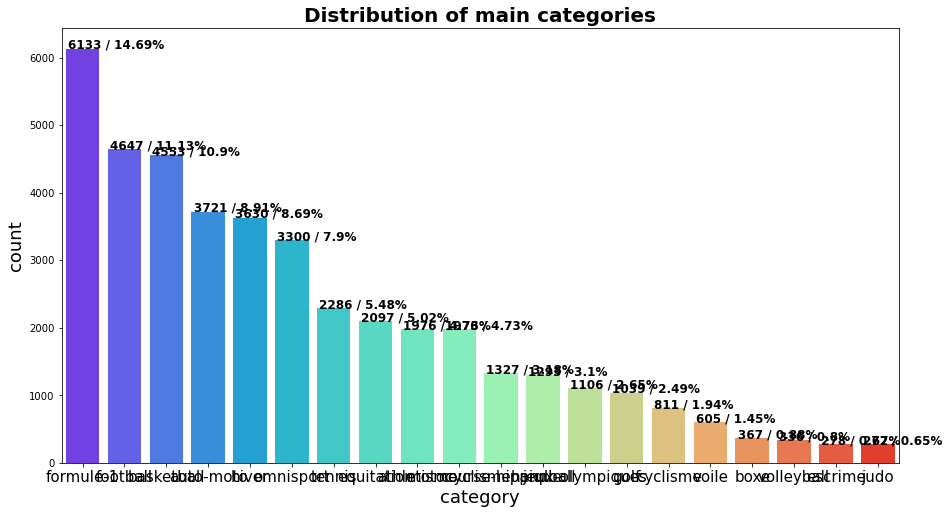

In [13]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(df['category'], order=df['category'].value_counts().index, palette='rainbow', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15, rotation=0)
ax.set_ylabel('count', fontsize=18)
ax.set_xlabel('category', fontsize=18)
ax.set_title('Distribution of main categories', fontsize=20, weight='bold');

percentages = [c / df.shape[0] * 100 for c in df['category'].value_counts()]
for percentage, count, p in zip(percentages,
                               df['category'].value_counts().tolist(),
                               ax.patches):
    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.35
    y = p.get_y() + p.get_height()
    ax.annotate(str(count)+" / "+ str(percentage), (x, y), fontsize=12, fontweight='bold')
fig.savefig("dist_main_cats.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("dist_main_cats.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [14]:
# Pick 5 random samples from the dataframe
df.sample(5, random_state=0)

,url,title,sub_title,img_src,text,category,category_id
7841,https://www.eurosport.fr//football/d1-arkema/2...,D1 Arkema : Le PSG écrase Reims et passe provi...,D1 Arkema - Le PSG a empoché une facile victoi...,https://imgresizer.eurosport.com/unsafe/1200x0...,"Tranquille, le Paris SG a battu Reims (4-0) en...",football,1
33481,https://www.eurosport.fr//omnisport/shanghai-s...,"OL, Shanghai, Nadal, Tsonga, Sotchi, Rami : l'...","Il parait qu'un matin, ça ne sert à rien... sa...",https://imgresizer.eurosport.com/unsafe/1200x0...,"Lacombe tape du poing sur la table A Lyon, on ...",omnisport,12
6038,https://www.eurosport.fr//formule-1/tres-prome...,"""Très prometteur...""","Mario Theissen, directeur BMW Motorsport, nou...",https://imgresizer.eurosport.com/unsafe/1200x0...,"Honnêtement, n'avez vous jamais douté quant à ...",formule-1,0
26102,https://www.eurosport.fr//handball/championnat...,"Euro-2020 : Les Néerlandaises, championnes du ...","EURO 2020 - Les handballeuses néerlandaises, c...",https://imgresizer.eurosport.com/unsafe/1200x0...,Les compétitions se suivent et ne se ressemble...,handball,9
10214,https://www.eurosport.fr//football/ligue-1/201...,"Bras droit d'Enrique, selectionneur de la Roja...",LIGUE 1 - Peu connu du grand public avant son ...,https://imgresizer.eurosport.com/unsafe/1200x0...,Déjà un premier gros test pour Robert Moreno à...,football,1


In [15]:
# Group the dataframe by categories and count items ( number of news articles) in each category
df.groupby('category').category_id.count()

category
athletisme         1976
auto-moto          3721
basketball         4553
boxe                367
course-hippique    1327
cyclisme            811
equitation         2097
escrime             278
football           4647
formule-1          6133
golf               1039
handball           1293
hiver              3630
jeux-olympiques    1106
judo                272
motocyclisme       1976
omnisport          3300
tennis             2286
voile               605
volleyball          336
Name: category_id, dtype: int64

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
#clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))
#clf.fit(X, y)

models = [
    LinearSVC(random_state=0, C=0.1, tol=1e-5, max_iter=8000,),
    RidgeClassifier(tol=1e-5, solver="sag",max_iter=8000),
    SGDClassifier(alpha=.0001, max_iter=8000,),
    LogisticRegression(random_state=0, max_iter=8000, C=30, tol=1e-5,)
]

SyntaxError: invalid syntax (<ipython-input-16-fb80c3b7ef66>, line 22)

In [ ]:
CV = 5  # Cross Validate with 5 different folds of 20% data ( 80-20 split with 5 folds )

#Create a data frame that will store the results for all 5 trials of the 3 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] # Initially all entries are empty

In [ ]:
#For each Algorithm 
for model in models:
  model_name = model.__class__.__name__
  print(model_name )
  # create 5 models with different 20% test sets, and store their accuracies
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 3x5 = 15 entries)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

In [ ]:
# Store the entries into the results dataframe and name its columns    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(x='model_name', y='accuracy', data=cv_df, palette='Dark2', ax=ax)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
fig.savefig("valid_boxplots.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [ ]:
# Mean accuracy of each algorithm
cv_df.groupby('model_name').accuracy.mean()#  

In [ ]:
model = LinearSVC(random_state=0,  C=0.1, tol=1e-5, max_iter=1000)
model = LogisticRegression(random_state=0, C=5, tol=1e-5, max_iter=5000)
#model= RidgeClassifier(tol=1e-5, solver="sag",max_iter=5000)
#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, stratify=df.category, test_size=0.2, random_state=0)

#Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

filename = 'LogisticRegression.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
plt.figure(figsize=(12, 12))
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig("confusion_matrix.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')


In [ ]:
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

In [ ]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories",
              help="Whether to use all categories or not.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()

In [ ]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
print("=" * 80)
print("LogisticRegression")
results.append(benchmark(LogisticRegression(random_state=0)
                        ))

for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))


# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

In [ ]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.savefig("benchmarks.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
plt.savefig("dist_main_cats.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')
plt.show()
